# WVD Testing

In [9]:
import h5py
import os.path
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# Check if dataset is present

dataset_path = "/mnt/datasets/RadioML/2018.01/GOLD_XYZ_OSC.0001_1024.hdf5"
os.path.isfile(dataset_path)


# Prepare data loader


class radioml_18_dataset(Dataset):
    def __init__(self, dataset_path):
        super(radioml_18_dataset, self).__init__()
        h5_file = h5py.File(dataset_path,'r')
        self.data = h5_file['X']
        self.mod = np.argmax(h5_file['Y'], axis=1) # comes in one-hot encoding
        self.snr = h5_file['Z'][:,0]
        self.len = self.data.shape[0]

        self.mod_classes = ['OOK','4ASK','8ASK','BPSK','QPSK','8PSK','16PSK','32PSK',
        '16APSK','32APSK','64APSK','128APSK','16QAM','32QAM','64QAM','128QAM','256QAM',
        'AM-SSB-WC','AM-SSB-SC','AM-DSB-WC','AM-DSB-SC','FM','GMSK','OQPSK']
        self.snr_classes = np.arange(-20., 32., 2) # -20dB to 30dB

        # do not touch this seed to ensure the prescribed train/test split!
        np.random.seed(2018)
        train_indices = []
        test_indices = []
        for mod in range(0, 24): # all modulations (0 to 23)
            for snr_idx in range(0, 26): # all SNRs (0 to 25 = -20dB to +30dB)
                # 'X' holds frames strictly ordered by modulation and SNR
                start_idx = 26*4096*mod + 4096*snr_idx
                indices_subclass = list(range(start_idx, start_idx+4096))
                
                # 90%/10% training/test split, applied evenly for each mod-SNR pair
                split = int(np.ceil(0.1 * 4096)) 
                np.random.shuffle(indices_subclass)
                train_indices_subclass = indices_subclass[split:]
                test_indices_subclass = indices_subclass[:split]
                
                # you could train on a subset of the data, e.g. based on the SNR
                # here we use all available training samples
                if snr_idx >= 4:
                    train_indices.extend(train_indices_subclass)
                test_indices.extend(test_indices_subclass)
                
        self.train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        self.test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    def __getitem__(self, idx):
        # transpose frame into Pytorch channels-first format (NCL = -1,2,1024)
        return self.data[idx].transpose(), self.mod[idx], self.snr[idx]

    def __len__(self):
        return self.len

dataset = radioml_18_dataset(dataset_path)

Modulation: OOK, SNR: 30.0 dB, Index: 102523


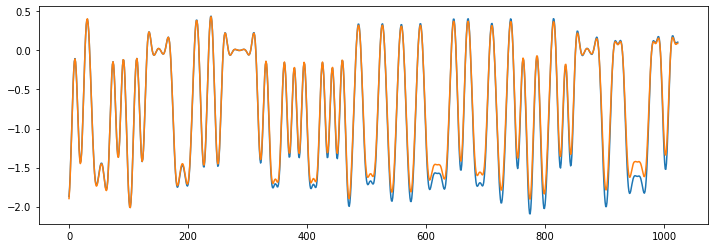

In [37]:
# Inspect a frame
mod = 0 # 0 to 23
snr_idx = 25 # 0 to 25 = -20dB to +30dB
sample = 123 # 0 to 4095
#-----------------------#
idx = 26*4096*mod + 4096*snr_idx + sample
data, mod, snr = dataset.data[idx], dataset.mod[idx], dataset.snr[idx]
plt.figure(figsize=(12,4))
plt.plot(data)
test_signal = data
print("Modulation: %s, SNR: %.1f dB, Index: %d" % (dataset.mod_classes[mod], snr, idx))

(1024, 2)
(1024,)
(1024, 2)


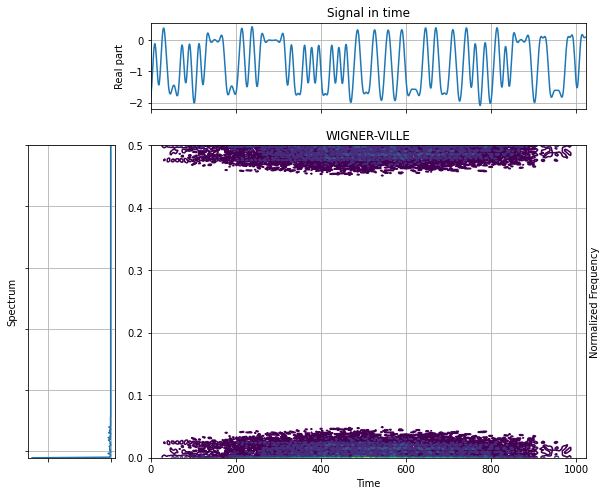

In [85]:
from tftb.processing import WignerVilleDistribution
print(test_signal.shape)
wvd_i = WignerVilleDistribution(test_signal[:,0])
wvd_q = WignerVilleDistribution(test_signal[:,1])
wvd_i_out = wvd_i.run()
wvd_q_out = wvd_q.run()
wvd_eig_iw, wvd_eig_iv = np.linalg.eig(wvd_i_out[0])
wvd_eig_qw, wvd_eig_qv = np.linalg.eig(wvd_q_out[0])

print(wvd_eig_iw.shape)
wvd_out = np.column_stack((wvd_eig_iw,wvd_eig_qw))
print(wvd_out.shape)
wvd.plot(kind='contour', show_tf=True)

## Convert to WVD Dataset

In [91]:
class radioml_18_dataset_wvd(Dataset):
    def __init__(self, dataset_path):
        super(radioml_18_dataset_wvd, self).__init__()
        h5_file = h5py.File(dataset_path,'r')
        self.data = h5_file['X']
        self.mod = np.argmax(h5_file['Y'], axis=1) # comes in one-hot encoding
        self.snr = h5_file['Z'][:,0]
        self.len = self.data.shape[0]

        self.mod_classes = ['OOK','4ASK','8ASK','BPSK','QPSK','8PSK','16PSK','32PSK',
        '16APSK','32APSK','64APSK','128APSK','16QAM','32QAM','64QAM','128QAM','256QAM',
        'AM-SSB-WC','AM-SSB-SC','AM-DSB-WC','AM-DSB-SC','FM','GMSK','OQPSK']
        self.snr_classes = np.arange(-20., 32., 2) # -20dB to 30dB

        # do not touch this seed to ensure the prescribed train/test split!
        np.random.seed(2018)
        train_indices = []
        test_indices = []
        for mod in range(0, 24): # all modulations (0 to 23)
            for snr_idx in range(0, 26): # all SNRs (0 to 25 = -20dB to +30dB)
                # 'X' holds frames strictly ordered by modulation and SNR
                start_idx = 26*4096*mod + 4096*snr_idx
                indices_subclass = list(range(start_idx, start_idx+4096))
                
                # 90%/10% training/test split, applied evenly for each mod-SNR pair
                split = int(np.ceil(0.1 * 4096)) 
                np.random.shuffle(indices_subclass)
                train_indices_subclass = indices_subclass[split:]
                test_indices_subclass = indices_subclass[:split]
                
                # convert to training set to wvd
                wvd_i_train = WignerVilleDistribution(np.array(train_indices_subclass))
                wvd_q_train = WignerVilleDistribution(np.array(train_indices_subclass))
                wvd_i_train_out = wvd_i_train.run()
                wvd_q_train_out = wvd_q_train.run()
                wvd_eig_iw, wvd_eig_iv = np.linalg.eig(wvd_i_train_out[0])
                wvd_eig_qw, wvd_eig_qv = np.linalg.eig(wvd_q_train_out[0])
                wvd_out_train = np.column_stack((wvd_eig_iw,wvd_eig_qw))
                
                # convert to testing set to wvd
                wvd_i_test = WignerVilleDistribution(np.array(test_indices_subclass))
                wvd_q_test = WignerVilleDistribution(np.array(test_indices_subclass))
                wvd_i_test_out = wvd_i_test.run()
                wvd_q_test_out = wvd_q_test.run()
                wvd_eig_iw_test, wvd_eig_iv_test = np.linalg.eig(wvd_i_test_out[0])
                wvd_eig_qw_test, wvd_eig_qv_test = np.linalg.eig(wvd_q_test_out[0])
                wvd_out_test = np.column_stack((wvd_eig_iw_test,wvd_eig_qw_test))
                
                # you could train on a subset of the data, e.g. based on the SNR
                # here we use all available training samples
                if snr_idx >= 4:
                    train_indices.extend(wvd_out_train)
                test_indices.extend(wvd_out_test)
        
       
        self.train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        self.test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    def __getitem__(self, idx):
        # transpose frame into Pytorch channels-first format (NCL = -1,2,1024)
        return self.data[idx].transpose(), self.mod[idx], self.snr[idx]

    def __len__(self):
        return self.len

dataset2 = radioml_18_dataset_wvd(dataset_path)

KeyboardInterrupt: 